[Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview)

toxicity的类型有：

- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

一个评论可以属于0到多个标签。

![image-20201226152702981](images/image-20201226152702981.png)



## 获取数据

首先引入需要的包。

In [34]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from nltk.corpus import stopwords
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 

base_path = os.path.abspath('/tf/eipi10/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# 设置GPU内存自动扩增
qtf.utils.set_gpu_memory_growth()
nltk.download('stopwords')

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

初始化参数。

In [37]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr



output_path = os.path.abspath('./output')
data_name = 'toxicity-16k'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

params = {
    'data_name': data_name,
    'data_path': data_path,
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'text_columns': 'snps_sa_comments',
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'stop_words':stopwords.words('english'),
    'batch_size': 32,    
    'max_features': 30000,
    'sequence_length': 100,    
    'epochs': 3,    
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':[metrics.BinaryAccuracy(), metrics.AUC(name='auc', multi_label=True)], 
    'loss': losses.BinaryCrossentropy(from_logits=False),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':True,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_binary_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_binary_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.6, 'layer_count':1, 'units':256, 'epochs':5},
        'rnn':{'dropout':0.4, 'embedding_dim':200, 'units':200, 'epochs':3},
        'embedding':{'dropout':0.4, 'embedding_dim':200, 'epochs':3},
        'sepcnn':{'dropout':0.4, 'epochs': 3, 'batch_size':128},
        'tl':{'dropout':0.4, 'trainable':True, 'layer_count':1, 'unit':64, 'epochs': 5},
        'pg':{'dropout':0.4, 'embedding_dim':300, 'units':80, 'epochs':6, 'learning_rate':0.0005},  
    },
    'embedding_paths':{
        'cc_en_300':os.path.join(word_vectors_path, 'snps', 'cc.en.300.vec'),
        'fasttext_crawl_300d_2M':os.path.join(word_vectors_path, 'fasttext-crawl-300d-2M.vec'),
        'glove_twitter_27B_200d':os.path.join(word_vectors_path, 'glove.twitter.27B.200d.txt')
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

### 加载数据

开始加载数据。数据下载自https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data 。其中有三个文件，分别是：

- train.csv：  训练数据，包含文本和标签
- test.csv： 测试数据，只包含文本
- test_labels.csv：测试数据标签，只包含文本标签

In [4]:
df_train = pd.read_csv('../data/jigsaw-toxic-comment-classification-challenge/train.csv')
df_test_data = pd.read_csv('../data/jigsaw-toxic-comment-classification-challenge/test.csv')
df_test_labels = pd.read_csv('../data/jigsaw-toxic-comment-classification-challenge/test_labels.csv')

print('-'*100) 
print('df_train=', len(df_train))
print('-'*100) 
print('df_test_data', len(df_test_data))
print('-'*100) 
print('df_test_labels', len(df_test_labels))

----------------------------------------------------------------------------------------------------
df_train= 159571
----------------------------------------------------------------------------------------------------
df_test_data 153164
----------------------------------------------------------------------------------------------------
df_test_labels 153164


In [5]:
print('-'*100) 
print(df_train.info())
print('-'*100) 
print(df_test_data.info())
print('-'*100) 
print(df_test_labels.info())

----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
None
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----

In [6]:
display(df_train.head())
display(df_test_data.head())
display(df_test_labels.head())

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


,id,comment_text
0,00001cee341fdb12,"Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"
1,0000247867823ef7,"== From RfC == \n\n The title is fine as it is, IMO."
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lapland — / """
3,00017563c3f7919a,":If you have a look back at the source, the information I updated was the correct form. I can only guess the source hadn't updated. I shall update the information once again but thank you for your message."
4,00017695ad8997eb,I don't anonymously edit articles at all.


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [7]:
df_test = df_test_data.join(df_test_labels.set_index('id'), on='id')
print('df_test=', len(df_test))
print('-'*100) 
display(df_test.sample(5))

df_test= 153164
----------------------------------------------------------------------------------------------------


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
29878,31bb63698b6d951e,""" \n\n == The Other 48 Days == \n\n There was no """"flashback"""" in this episode. The only argument that there was a flashback would be because the other episodes had reached a certain point in time, and this covered a time period already covered in previous episodes. However, if you were to use that argument, you would have to count Locke and Kate's entire plotline in """"Adrift"""" as a """"Flashback"""" because it ends at the same point as """"Man of Science, Man of Faith"""". """,0,0,0,0,0,0
57422,5f891066eacf112a,""" \n ::: ~slips out of semi-retirement to tell you Congrats!~ // """,0,0,0,0,0,0
101485,a961e9a95f338902,""" \n\n ==Copyright problem: Polo in India== \n Hello, and welcome to Wikipedia! We welcome and appreciate your contributions, such as Polo in India, but we regretfully cannot accept copyrighted text or images borrowed from either web sites or printed material. This article appears to contain material copied from http://www.isrj.net/June/2011/Research_Paper_Problems_and_Prospects_of_Indian_Sports.html, and therefore to constitute a violation of Wikipedia's copyright policies. The copyrighted text has been or will soon be deleted. While we appreciate contributions, we must require all contributors to understand and comply with our copyright policy. Wikipedia takes copyright violations very seriously, and persistent violators are liable to be blocked from editing. \n\n If you believe that the article is not a copyright violation, or if you have permission from the copyright holder to release the content freely under license allowed by Wikipedia, then you should do one of the following: \n\n :*If you have permission from the author to release the text under the Creative Commons Attribution-ShareAlike License (CC-BY-SA), leave a message explaining the details at Talk:Polo in India and send an email with confirmation of permission to """"permissions-en (at) wikimedia (dot) org"""". Make sure you quote the exact page name, Polo in India, in your email. See Wikipedia:Requesting copyright permission for instructions. \n :*If a note on the original website states that re-use is permitted """"under the Creative Commons Attribution-ShareAlike License (CC-BY-SA), version 3.0, or that the material is released into the public domain leave a note at Talk:Polo in India with a link to where we can find that note. \n :*If you own the copyright to the material: send an e-mail from an address associated with the original publication to permissions-en(at)wikimedia(dot)org or a postal message to the Wikimedia Foundation permitting re-use under the Creative Commons Attribution-ShareAlike License and GNU Free Documentation License, and note that you have done so on Talk:Polo in India. See Wikipedia:Donating copyrighted materials for instructions. \n It may also be necessary for the text be modified to have an encyclopedic tone and to follow Wikipedia article layout. For more information on Wikipedia's policies, see Wikipedia's policies and guidelines. \n\n If you would like to begin working on a new version of the article you may do so at [ this temporary page]. Leave a note at Talk:Polo in India saying you have done so and an administrator will move the new article into place once the issue is resolved. \n Thank you, and please feel welcome to continue contributing to Wikipedia. Happy editing! """,0,0,0,0,0,0
79854,85453aac4b8677e1,""" \n :You can use a """"user subpage"""" to save articles, if they are in such a state that you don't want to save it as a new version of the article yet. So if you're working on Phantom Falls and discover that you have to stop but don't want to save it, copy the text and edit instead. Save that, come back later, and copy the text again back to a new edit on Phantom Falls. (And you can request speedy-deletion of your user subpage when you're done with it with a tag. """,-1,-1,-1,-1,-1,-1
117537,c4323749

In [8]:
# 移除全部是-1的行
df_test = df_test.loc[df_test[params.classes].max(axis=1)>=0]

print('df_test=', len(df_test))
print('-'*100) 
display(df_test.sample(5))

df_test= 63978
----------------------------------------------------------------------------------------------------


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
115112,c01f5253de54dfc3,::I hate this.,0,0,0,0,0,0
76340,7f4ed164d1b0665e,""" \n\n ==Gradient== \n\n The article contains the following... \n Maximum Steepness: 64% \n ...where does 64% come from? \n The official site says... \n """"When finished, the track measured 201 ft long, with a vertical rise of 111ft. This gave the railway an incline of 33°, the steepest in England."""" \n The sign at the top of the railway in Bridgnorth also says 33°; I've also checked the maths and I get 33.5°""",0,0,0,0,0,0
3908,06aebc0d0264bd24,== Fuck off == \n\n SLAG OFF.,1,0,1,0,0,0
68897,72aecf5a63b0b461,""" \n\n == Reputation of the US government is in your hands only (USA.GOV) == \n\n COPY OF NOTIFICATION FOR JIMBO WALES (WIKIPEDIA) \n\n Being with common sense in the head (we hope), you get now this notification. If you are agree, that this page http://my.mail.ru/community/beatleshigher80/5D41A96A3912D33.html must contain Gestapo with the US government (in the one place), you can make rollback and nothing do. If you respect your government, you must delete the page http://en.wikipedia.org/wiki/Wikipedia:WikiProject_Spam/Local/epetitions.direct.gov.uk with slander and insult against the Monarchy. You have no respecting to the UK government - all of us already understood (but this fact not has meaning). Currently you can select: the US government together with the Gestapo will travel around the world, and will be placed on the official websites of the UN (branches - including). Reminder: all of this can be the only stupid tale, but in the one case only: deletion of the page http://en.wikipedia.org/wiki/Wikipedia:WikiProject_Spam/Local/epetitions.direct.gov.uk with slanders in relation of the UK government and its citizens. This notification was saved already, and your government can get all information even now (in any moment). Social networks and other millions of methods - including (a large number of state agencies can get this also). Main thing: any method of rollback of this notification - only your responsibility (rollback from the side of your stupid admins creates the obligation - you must delete such vandalism via rollback in relation of them). You can delete this message in the only one case: when you deleted page with insult in relation of the Monarchy. Your government can be in order only after this action. Friendship with the Gestapo will be finished. - .""",0,0,0,0,0,0
51691,55c9960218348af9,These rules include:,0,0,0,0,0,0


看了一些kaggle上别人的模型，看上去他们那时候的数据集时直接把训练数据拆分的。

In [9]:
df_train, df_test = train_test_split(df_train, test_size=0.05, random_state=233)

In [10]:
print('-'*100) 
print('df_train=', len(df_train))
print('-'*100) 
print('df_test', len(df_test))
display(df_train.sample(5))
display(df_test.sample(5))

----------------------------------------------------------------------------------------------------
df_train= 151592
----------------------------------------------------------------------------------------------------
df_test 7979


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
112537,5a0d2abb47a2a3e4,I'm not sure why one AFD equals consensus but alright whatever.,0,0,0,0,0,0
34561,5c4838b8e656f2c9,Lead \n\nThe last sentence of the third paragraph is quite long and complex grammatically. Perhaps it could be rewritten or broken into multiple sentence to aid readability.,0,0,0,0,0,0
16251,2ad8e9812c53baaa,"Wikipedia:WikiProject_Hertfordshire \n\nhope you like the front page for the project, I updated it, made it a yellow style.",0,0,0,0,0,0
77214,cecec0fcbd682390,"I vote that your a fucking asshole with a stick up your ass, and you somehow are retarted enough to believe or like this shit, or you somehow believe its acceptable for people to believe it, fucking idiot, your are a total waste of life!!!",1,0,1,0,1,0
138261,e3dab04f1cbdf1f9,(second level warning) >,0,0,0,0,0,0


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
4882,0cec1f1b06ba256b,If you are interested in contributing more to kayaking or canoeing related articles you may want to join WikiProject Kayaking.,0,0,0,0,0,0
121455,89d2d0c904ad3c90,"Half of 26 are what I hope seeing \n\nBetter solutions could be Crab walks sideways, Chimpanzee eats bugs, crow thieves, Fox prowls, ect.",0,0,0,0,0,0
110489,4f20d08d4be00f32,"""\n\nThen all is well. Just don't forget """"Jones"""", when you abandon ship. """,0,0,0,0,0,0
124347,992f2ebe1c30a785,"Getting angry above about it doesn't change the undeniable fact that it needs to go to the main subject. You've also broken WP:3RR. And I hate musicals, especially the one with the singing nuns.",0,0,0,0,0,0
138290,e3f1e68c5b137052,"I'm simply saying that that's a comic COVER. It's public. It's a widely known thing, like the cover of a novel. If DC wants the reader to know when they see it on the newsstand, then it's not a spoiler.",0,0,0,0,0,0




### 查看数据

下面看一看实际的数据是啥样的。

In [11]:
for i, row in df_train.sample(5).iterrows():
    print('-'*100) 
    display(row.to_frame().T[params.classes]) 
    print(row["comment_text"]) 

----------------------------------------------------------------------------------------------------


,toxic,severe_toxic,obscene,threat,insult,identity_hate
32759,0,0,0,0,0,0


Do as you wish, at the templates.
----------------------------------------------------------------------------------------------------


,toxic,severe_toxic,obscene,threat,insult,identity_hate
64958,0,0,0,0,0,0


"

Re:Obould Many Arrows
I can back it up. If you go to the R A Salvatore home page there is a sample chapter of the new book, The Orc King. It names the Obould in that book as Obould the 6th. It also clearly states that the book is set a century after. Thank You for your concern. Drizzt mo "
----------------------------------------------------------------------------------------------------


,toxic,severe_toxic,obscene,threat,insult,identity_hate
99724,0,0,0,0,0,0


Jehochman, you appear to be working under the misunderstanding that just because an article is listed on the main page it can't be tagged for problems. That's ass-backward. It's wrong. It's not based on any policy I can think of (indeed, that would be against policy). Please don't dispense this misinformation with this tone of faux-authority as it is clear you're out of your element when it comes to content policies. And seriously, edit warring by an admin is bad enough by itself.
----------------------------------------------------------------------------------------------------


,toxic,severe_toxic,obscene,threat,insult,identity_hate
33200,1,0,1,0,1,1


What?? 

Go lick a pig you arab muslim peice of scum.
----------------------------------------------------------------------------------------------------


,toxic,severe_toxic,obscene,threat,insult,identity_hate
139029,0,0,0,0,0,0


Iron Man
Hi, Horkana. Always good to see your name on an edit!

My concern is that runtimes are notoriously difficult to pin down  it's one of the banes of my existence in my capacity as a film critic. If WP:FILM doesn't require a cite for runtime, I'm perfectly cool with that, of course. It's just that in practical terms, I've found that for almost every film, different sources given different runtimes, and so it'd be good to know where a particular number came from. You have more experience in film-article editing, so I'll follow your lead  whatever you think best. Keep up the great editing!




## 探索数据

接下来，对把数据加载进内存，进行深入一些的探索。

### 基本信息

In [12]:
def get_samples(texts, labels, rate):
    indexs = np.arange(len(texts))
    sample_indexs, _, sample_labels, _ = train_test_split(indexs, labels,                                                          
                                                          test_size=1-rate,
                                                          random_state=12)
    sample_texts = [texts[index] for index in sample_indexs]
    return sample_texts, sample_labels    

def load_toxicity(df, classes=params.classes):
    
    texts = list(df['comment_text'])
    labels = df[classes].to_numpy()

    return texts, labels

train_texts, train_labels = load_toxicity(df_train)
test_texts, test_labels = load_toxicity(df_test)


if params.sample_perecent<1:
    train_texts, train_labels = get_samples(train_texts, train_labels, rate=params.sample_perecent)
    test_texts, test_labels = get_samples(test_texts, test_labels, rate=params.sample_perecent)

print('train_texts.length={}, train_labels.shape={}'.format(len(train_texts), train_labels.shape))
print('test_texts.length={}, test_labels.shape={}'.format(len(test_texts), test_labels.shape))

train_texts.length=151592, train_labels.shape=(151592, 6)
test_texts.length=7979, test_labels.shape=(7979, 6)


In [13]:
test_texts[0]

"Misplaced article\nI noticed that you began to write an article at Portal:Contents.\nI have undone your edit there, because that page is one of the encyclopedia's main index pages. It is not a good place to submit content for the encyclopedia.\nI suggest that you look at Wikipedia:Your first article and perhaps try again using the Article wizard."

### 类别分布

下面看看类别的分布。可以看到数据分为Positive和Negative两类，数据分布完全均匀。

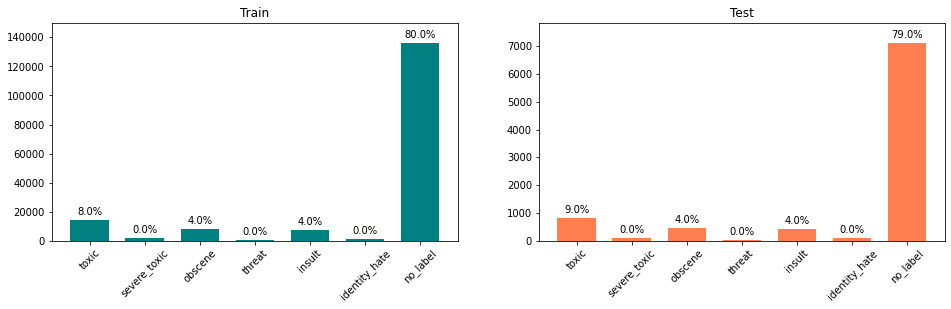

In [14]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



### 文本长度分布

分析训练集和测试集的文本长度分布是否相似。

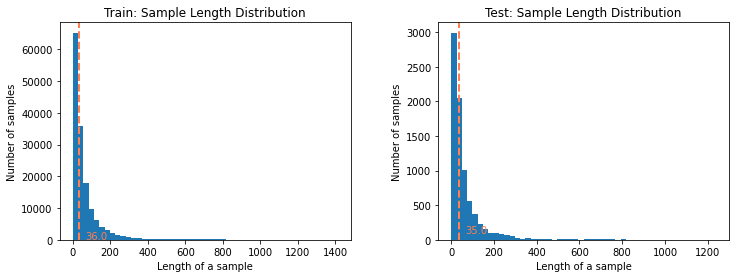

train：mean=67.36 variance=9872.86
test：mean=65.68 variance=9346.42


In [15]:
train_text_lengths = [len(s.split()) for s in train_texts]
test_text_lengths = [len(s.split()) for s in test_texts]
qtf.utils.plot_length_distribution(train_text_lengths, test_text_lengths)

print('train：mean={:0.2f} variance={:0.2f}'.format(np.mean(train_text_lengths), 
                                                    np.var(train_text_lengths)))
print('test：mean={:0.2f} variance={:0.2f}'.format(np.mean(test_text_lengths), 
                                                   np.var(test_text_lengths)))


通过图形，中位数，均值和方差的比较，可以认为训练集和测试集文本长度的分布是非常相似的。下面用卡方检验来比较训练集和测试集是否有显著差异。

In [16]:
def process_length(lengths):
    cut_points = [0,99,199,299,399,499,599,699,799,10000]
    labels = ["0-99","100-199","200-299","300-399","400-499","500-599", "600-699","700-799","800+"]
    return pd.cut(lengths, cut_points, labels=labels)

def get_observed(df, column1, column2):
    df_observed = pd.crosstab(
        df[column1],
        df[column2]
    )    
    return df_observed
    
def get_expected(df_observed):
    observed = df_observed.to_numpy()
    reduce_row = observed.sum(axis=0, keepdims=True)/observed.sum()
    reduce_col = observed.sum(axis=1, keepdims=True)

    expected = reduce_col.dot(reduce_row)
    df_expected = pd.DataFrame(expected, index=df_observed.index, columns=df_observed.columns)
    return df_expected
  
def show_sum(df):
    df.columns =  df.columns.tolist()  
    df = df.reset_index()
    s = df.melt(df.columns[0], var_name=' ')
    ct = pd.crosstab(index=s[df.columns[0]], columns=s.iloc[:,1], values=s.value, 
                     aggfunc='sum', margins=True, margins_name='合计',
                     rownames=[''], 
               ) 
    display(ct)
    
length = train_text_lengths + test_text_lengths
dataset = ['train']*len(train_text_lengths) + ['test']*len(test_text_lengths)

df_length = pd.DataFrame({"dataset":dataset, "length":length})
df_length['len'] = process_length(length)
df_observed = get_observed(df_length, 'dataset', 'len')
# display(df_length)

print('-'*25, 'Observed', '-'*25)
show_sum(df_observed)

print('-'*25, 'Expected', '-'*25)
df_expected = get_expected(df_observed)
show_sum(df_expected)

------------------------- Observed -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,6609,872,283,76,42,33,29,19,16,7979
train,124400,17522,5032,1770,897,624,558,481,308,151592
合计,131009,18394,5315,1846,939,657,587,500,324,159571


------------------------- Expected -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,6550.819453,919.751872,265.764989,92.305206,46.952648,32.851853,29.351655,25.00141,16.200914,7979.0
train,124458.180547,17474.248128,5049.235011,1753.694794,892.047352,624.148147,557.648345,474.99859,307.799086,151592.0
合计,131009.000000,18394.000000,5315.000000,1846.000000,939.000000,657.000000,587.000000,500.00000,324.000000,159571.0


![image-20210101174143400](images/image-20210101174143400.png)

然后进行卡方检验。可以看到p_value>0.05，所以接受原假设——数据集来源和文本长度是独立的，也就是说接受训练集和测试集是是相似的分布。

In [17]:
observed = df_observed.to_numpy()
expected = df_expected.to_numpy()

chi_squared_stat = ((observed-expected)**2/expected).sum()
print('chi_squared_stat =', chi_squared_stat)

df = np.prod(np.array(observed.shape) - 1)
critical_value  = stats.chi2.ppf(q=0.95, df=df)  #0.95:置信水平, df:自由度
print('critical_value =', critical_value)        #临界值:拒绝域的边界, 当卡方值大于临界值，则原假设不成立，备择假设成立

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=df)
print('p_value =', p_value)

chi_squared_stat = 9.436054249482249
critical_value = 15.50731305586545
p_value = 0.3068556587694957



### 词频分布

分析训练集和测试集的词频分布是否相似。下面代码中，去除了一些stopwords。

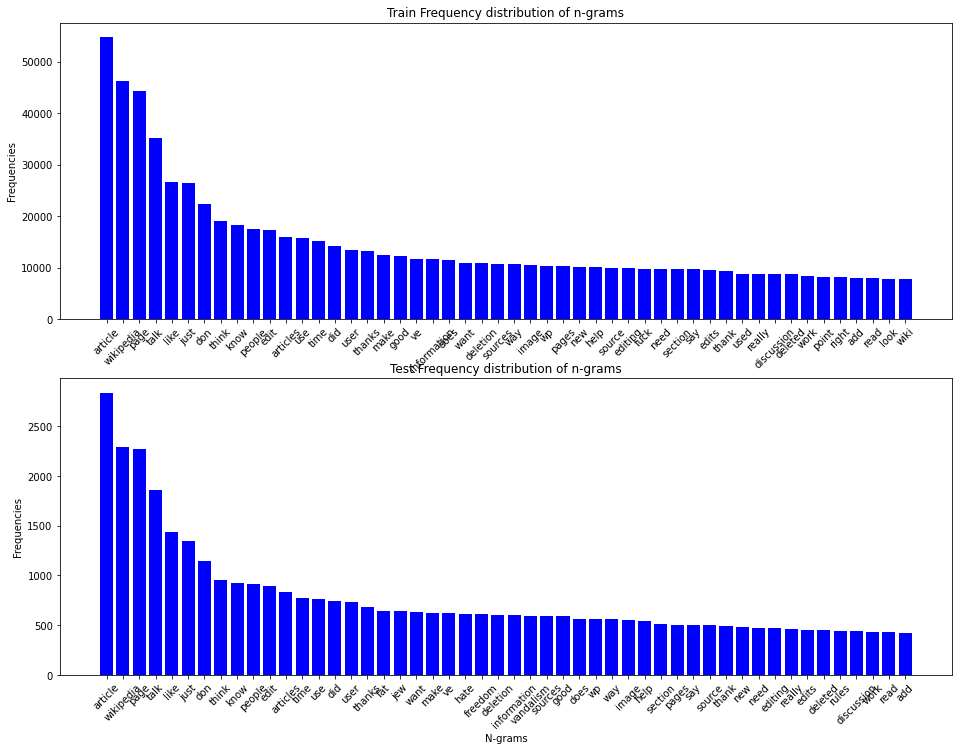

In [18]:
qtf.utils.plot_frequency_distribution(train_texts, test_texts) 

In [19]:
word_counter = Counter()
for s in train_texts:
    word_counter.update(s.split())
for s in test_texts:
    word_counter.update(s.split())   

print('Number of Vocabulary: {}'.format(len(word_counter)))

for word in list(word_counter):
    if word_counter[word]<25: word_counter.pop(word)
        
print('Number of Vocabulary: {}'.format(len(word_counter)))

Number of Vocabulary: 532299
Number of Vocabulary: 19973




## 准备数据

不同的模型需要准备不同的数据，所以徐要确定一下要构建哪种模型。

### 模型选择

下图是google在两年前提出一个选择流程图。

![image-20201217135347743](images/image-20201217135347743.png)

1. Calculate the number of samples/number of words per sample ratio.
2. If this ratio is less than 1500, tokenize the text as n-grams and use a simple multi-layer perceptron (MLP) model to classify them (left branch in the flowchart below):
   a. Split the samples into word n-grams; convert the n-grams into vectors.
     b. Score the importance of the vectors and then select the top 20K using the scores.
   c. Build an MLP model.
3. If the ratio is greater than 1500, tokenize the text as sequences and use a sepCNN model to classify them (right branch in the flowchart below):
   a. Split the samples into words; select the top 20K words based on their frequency.
   b. Convert the samples into word sequence vectors.
   c. If the original number of samples/number of words per sample ratio is less   than 15K, using a fine-tuned pre-trained embedding with the sepCNN  model will likely provide the best results.
4. Measure the model performance with different hyperparameter values to find
   the best model configuration for the dataset.

In [20]:
length_median = np.median(train_text_lengths)
train_number = len(train_texts)
print ("[the number of samples]/[number of words per sample] = {:0.1f}".format(train_number/length_median))

[the number of samples]/[number of words per sample] = 4210.9


可以看到这个比例大大小于15k，所以我们从N-gram模型开始，但是同时我们也会为Sequence模型准备数据。数据准备有如下几个过程。
1. Standardization 
   
   文本标准化操作，去除一些不合规范的字符或单词等。比如：去除拼音和HTML标记
   
   
2. Tokenization

   把文本字符串拆分成Token。对于英文最常见的拆分方式是根据空格拆分
   
   
3. Vectorization

   把Token转化为向量。
   

接下来，我们将分别为N-gram模型和Sequence模型准备数据。

### N-gram + Preprocess

在N-gram模型中，Tokenization一般使用unigrams + bigrams的方式把文本转成Token，而Vectorization过程，一般先统计Token的BOW（Bag of Words，词袋模型），然后采用tf-idf在对词频进行平衡。

In [21]:
stop_words = params.stop_words if params.use_stop_words else None
generator = qtf.text.NgramGenerator('ngram_preproess', standardize=qtf.text.standardize_text1,
                                    texts=train_texts, labels=train_labels, max_feature=params.max_features, 
                                    stop_words=stop_words)
ngram_datasets1 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels, 
                                              generator=generator, batch_size=params.batch_size)

In [22]:
len(generator.vectorizer.vocabulary_)

562985

In [23]:
data, labels = iter(ngram_datasets1.train_dataset).next()
print(type(data))
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(tf.sparse.to_dense(data), labels)):
    if i>=5: break
    label_ = ', '.join([params.classes[i] for i, l in enumerate(label) if l>0])
    print('-'*40, label_, '-'*40)
    print(np.any(item.numpy()>0), item.shape)

<class 'tensorflow.python.framework.sparse_tensor.SparseTensor'>
(32, 30000) (32, 6)
---------------------------------------- toxic, obscene, insult ----------------------------------------
True (30000,)
----------------------------------------  ----------------------------------------
True (30000,)
----------------------------------------  ----------------------------------------
True (30000,)
----------------------------------------  ----------------------------------------
True (30000,)
----------------------------------------  ----------------------------------------
True (30000,)


### Sequence + Preprocess

In [24]:
generator = qtf.text.SequenceGenerator('sequence_prepross', standardize=qtf.text.standardize_text1, 
                                       texts=train_texts, max_features=params.max_features, 
                                       max_sequence_length=params.sequence_length)
sequence_datasets1 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels, 
                                                 generator=generator, batch_size=params.batch_size) 

In [25]:
data, labels = iter(sequence_datasets1.train_dataset).next()
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(data, labels)):
    if i>=5: break
    label_ = ', '.join([params.classes[i] for i, l in enumerate(label) if l>0])
    print('-'*40, label_, '-'*40)
    print(item.numpy(), item.shape)

(32, 100) (32, 6)
----------------------------------------  ----------------------------------------
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    5  172  266
 2694   41   82  757    8  161   33    3   32   11   23   58   43    1
    1    1] (100,)
----------------------------------------  ----------------------------------------
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 2738  323  218   25  134    4    2 2509   92  104
    3    5  606   25 1016    6    2  994 1698 1983  257 1064    7 2376
 5145    1    1 

### N-gram + Process

In [26]:
generator = qtf.text.LayerGenerator.get_ngram_layer(name='ngram_map', standardize=qtf.text.standardize_tf_text1, 
                                                        texts=train_texts, max_features=params.max_features)
ngram_datasets2 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels, 
                                              generator=generator, batch_size=params.batch_size)

In [27]:
data, labels = iter(ngram_datasets2.train_dataset).next()
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(data, labels)):
    if i>=5: break
    label_ = ', '.join([params.classes[i] for i, l in enumerate(label) if l>0])
    print('-'*40, label_, '-'*40)
    print(item.numpy(), item.shape)

(32, 30000) (32, 6)
----------------------------------------  ----------------------------------------
[696.52155   10.052714   0.       ...   0.         0.         0.      ] (30000,)
----------------------------------------  ----------------------------------------
[170.5767      1.8277663   0.        ...   0.          0.
   0.       ] (30000,)
----------------------------------------  ----------------------------------------
[355.36813     3.6555326   2.9680228 ...   0.          0.
   0.       ] (30000,)
----------------------------------------  ----------------------------------------
[2253.034      13.708247   29.68023  ...    0.          0.
    0.      ] (30000,)
----------------------------------------  ----------------------------------------
[49.75154  0.       0.      ...  0.       0.       0.     ] (30000,)


### Sequence + Process

![Embedding Layer](images/EmbeddingLayer.png)

如上图所示，和N-gram模型不同，Sequence模型并不统计词频，它保持了文本的原始顺序，把其中的每个词汇单独变成一个One-hot向量，然后采用Word embedding的方式生成更加有意义的词向量，最后输出到RNN，CNN等模型中。

In [28]:
generator = qtf.text.LayerGenerator.get_sequence_layer(name='sequence_map', 
                                                       standardize=qtf.text.standardize_tf_text1, 
                                                       texts=train_texts, 
                                                       max_features=params.max_features,
                                                       max_sequence_length=params.sequence_length)
sequence_datasets2 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels,   
                                                 generator=generator, batch_size=params.batch_size)

In [33]:
data, labels = iter(sequence_datasets2.train_dataset).next()
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(data, labels)):
    if i>=5: break
    label_ = ', '.join([params.classes[i] for i, l in enumerate(label) if l>0])
    print('-'*40, label_, '-'*40)
    print(label)
    print(item.numpy(), item.shape)

(32, 100) (32, 6)
----------------------------------------  ----------------------------------------
tf.Tensor([0 0 0 0 0 0], shape=(6,), dtype=int64)
[5334 4595  604   21 1103  365   72   11   21    5 1103 2783   11   21
    8  323   13   64 1729    3  167   93 1297    3   14   32   25   49
   42 1367    2 1646    5    1   20   33  960 1306 1171    3   14   32
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0] (100,)
----------------------------------------  ----------------------------------------
tf.Tensor([0 0 0 0 0 0], shape=(6,), dtype=int64)
[   76   493    98    13     2   991     1   136  1179     4    60   531
    84     2    76   899    61 13504     6    47   270     3    12   555
    45     2   143    11    21   549    13    40     3

In [30]:
vocabulary = generator.layer.get_vocabulary()

embedding_files = [params.embedding_paths.fasttext_crawl_300d_2M]
embedding_matrix_fasttext = qtf.text.load_embedding_matrix(embedding_files,
                                                           vocabulary=vocabulary,
                                                           max_features=params.max_features,
                                                           max_length=1000000,
                                                           ignore_rows=0
                                                           )

2021-07-24 22:44:51,006: INFO: --------------------------------------------------------------------------------
2021-07-24 22:45:53,026: INFO: Loaded 1000000 word vectors. the vector size is 300
2021-07-24 22:45:53,080: INFO: embedding_matrix.shape: (30000, 300)
2021-07-24 22:45:53,081: INFO: match count: 26924
2021-07-24 22:45:53,082: INFO: missing word count: 3076


上面结果可以看到，



##  模型

### MLP

#### mp1

2021-07-24 23:17:16,114: INFO: model_params.mlp1.dropout=0.6
2021-07-24 23:17:16,115: INFO: model_params.mlp1.layer_count=1
2021-07-24 23:17:16,116: INFO: model_params.mlp1.units=256
2021-07-24 23:17:16,170: INFO: output_bias=[-0.83046516 -3.09185542 -1.42323626 -4.31073893 -1.49321114 -3.22567087]
2021-07-24 23:17:16,178: INFO: learning_rate=0.001
2021-07-24 23:17:16,179: INFO: model_params.mlp1.clip_value=None
2021-07-24 23:17:16,185: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/mlp1
2021-07-24 23:17:16,188: INFO: model_params.mlp1.epochs=5
2021-07-24 23:17:16,189: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/mlp1, monitor=val_binary_accuracy)
2021-07-24 23:17:16,190: INFO: use EarlyStopping(monitor=val_binary_accuracy, patience=40)
2021-07-24 23:17:16,190: INFO: use ReduceLRO

SparseTensorSpec(TensorShape([32, 30000]), tf.float32)
Model: "mlp1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 30000)]           0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 30000)             0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 30000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               7680256   
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 1542      
Total params: 7,681,798
Trainable params: 7,681,798
Non-trainable params:

2021-07-24 23:17:39,385: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/mlp1/assets


Epoch 2/5
4737/4737 [==============================] - 21s 4ms/step - loss: 0.0836 - binary_accuracy: 0.9740 - auc: 0.8991 - val_loss: 0.0691 - val_binary_accuracy: 0.9767 - val_auc: 0.9464
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/mlp1/assets


2021-07-24 23:18:01,356: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/mlp1/assets


Epoch 3/5
4737/4737 [==============================] - 21s 4ms/step - loss: 0.0796 - binary_accuracy: 0.9752 - auc: 0.9110 - val_loss: 0.0674 - val_binary_accuracy: 0.9767 - val_auc: 0.9558
Epoch 4/5
4737/4737 [==============================] - 21s 4ms/step - loss: 0.0779 - binary_accuracy: 0.9758 - auc: 0.9163 - val_loss: 0.0668 - val_binary_accuracy: 0.9771 - val_auc: 0.9546
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/mlp1/assets


2021-07-24 23:18:44,481: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/mlp1/assets


Epoch 5/5
4737/4737 [==============================] - 21s 4ms/step - loss: 0.0767 - binary_accuracy: 0.9762 - auc: 0.9180 - val_loss: 0.0666 - val_binary_accuracy: 0.9769 - val_auc: 0.9543


2021-07-24 23:19:06,081: INFO: finish training [elapsed time: 109.89 seconds]


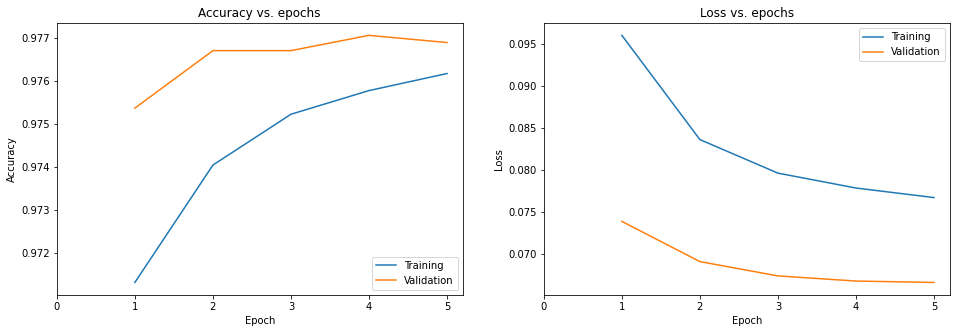

2021-07-24 23:19:06,411: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/mlp1
----------------------------------------evaluate----------------------------------------


2021-07-24 23:19:50,996: INFO: test loss:0.0668
2021-07-24 23:19:50,997: INFO: test binary_accuracy:0.9771
2021-07-24 23:19:50,998: INFO: test auc:0.4722
2021-07-24 23:19:50,999: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/results.json
2021-07-24 23:19:51,000: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/results.json
2021-07-24 23:19:51,001: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/ngram_preproess.generator


----------------------------------------save model results and generator----------------------------------------


2021-07-24 23:19:51,862: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/ngram_preproess.generator


----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_binary_accuracy,test_binary_accuracy,train_auc,test_auc
1,mlp1,7681798,109.4,0.0543,0.0668,0.9811,0.9771,0.5034,0.4722


In [40]:
helper = qtf.classification.Classification(params, datasets=ngram_datasets1, model_results=model_results)
model = qtf.classification.models.mlp1(helper, name='mlp1', last_activation='sigmoid')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True)

#### mlp2

2021-07-24 23:19:51,969: INFO: model_params.mlp2.dropout=0.6
2021-07-24 23:19:51,970: INFO: model_params.mlp2.layer_count=1
2021-07-24 23:19:51,970: INFO: model_params.mlp2.units=256
2021-07-24 23:19:51,990: INFO: output_bias=[-0.83046516 -3.09185542 -1.42323626 -4.31073893 -1.49321114 -3.22567087]
2021-07-24 23:19:51,997: INFO: learning_rate=0.001
2021-07-24 23:19:51,998: INFO: model_params.mlp2.clip_value=None
2021-07-24 23:19:52,003: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/mlp2
2021-07-24 23:19:52,005: INFO: model_params.mlp2.epochs=5
2021-07-24 23:19:52,005: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/mlp2, monitor=val_binary_accuracy)
2021-07-24 23:19:52,006: INFO: use EarlyStopping(monitor=val_binary_accuracy, patience=40)
2021-07-24 23:19:52,007: INFO: use ReduceLRO

TensorSpec(shape=(32, 30000), dtype=tf.float32, name=None)
Model: "mlp2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 30000)]           0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 30000)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               7680256   
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 1542      
Total params: 7,681,798
Trainable params: 7,681,798
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
4737/4737 [==============================] - 82s 

2021-07-24 23:21:14,862: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/mlp2/assets


Epoch 2/5
4737/4737 [==============================] - 20s 4ms/step - loss: 0.1518 - binary_accuracy: 0.9715 - auc: 0.8471 - val_loss: 0.1135 - val_binary_accuracy: 0.9712 - val_auc: 0.9181
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/mlp2/assets


2021-07-24 23:21:35,142: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/mlp2/assets


Epoch 3/5
4737/4737 [==============================] - 20s 4ms/step - loss: 0.1519 - binary_accuracy: 0.9723 - auc: 0.8468 - val_loss: 0.1252 - val_binary_accuracy: 0.9708 - val_auc: 0.9240
Epoch 4/5
4737/4737 [==============================] - 20s 4ms/step - loss: 0.1586 - binary_accuracy: 0.9723 - auc: 0.8495 - val_loss: 0.1231 - val_binary_accuracy: 0.9716 - val_auc: 0.9313
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/mlp2/assets


2021-07-24 23:22:15,156: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/mlp2/assets


Epoch 5/5
4737/4737 [==============================] - 20s 4ms/step - loss: 0.1608 - binary_accuracy: 0.9725 - auc: 0.8466 - val_loss: 0.1137 - val_binary_accuracy: 0.9707 - val_auc: 0.9118


2021-07-24 23:22:35,273: INFO: finish training [elapsed time: 163.27 seconds]


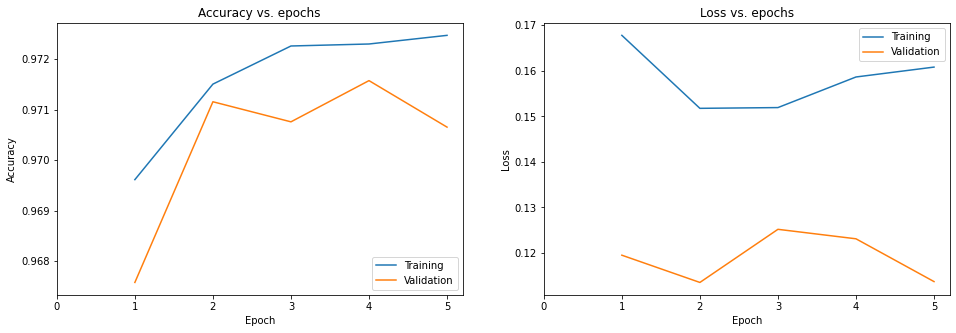

2021-07-24 23:22:35,598: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/mlp2


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/mlp2
----------------------------------------evaluate----------------------------------------


2021-07-24 23:24:06,328: INFO: test loss:0.0897
2021-07-24 23:24:06,330: INFO: test binary_accuracy:0.9716
2021-07-24 23:24:06,330: INFO: test auc:0.5058
2021-07-24 23:24:06,332: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/results.json
2021-07-24 23:24:06,334: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/results.json
2021-07-24 23:24:06,335: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/ngram_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-07-24 23:24:06,340: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-07-24 23:24:06,379: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/ngram_map.layer/assets


2021-07-24 23:24:07,137: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/ngram_map.layer/assets
2021-07-24 23:24:07,159: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/ngram_map.generator


----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_binary_accuracy,test_binary_accuracy,train_auc,test_auc
1,mlp1,7681798,109.4,0.0543,0.0668,0.9811,0.9771,0.5034,0.4722
2,mlp2,7681798,162.8,0.0746,0.0897,0.9753,0.9716,0.5004,0.5058


In [41]:
helper = qtf.classification.Classification(params, datasets=ngram_datasets2, model_results=model_results)
model = qtf.classification.models.mlp1(helper, name='mlp2', last_activation='sigmoid')
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

In [42]:
helper.model_summary(model, history, show_sample_analysis=True)

2021-07-24 23:24:07,289: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/mlp2


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/mlp2
----------------------------------------evaluate----------------------------------------


2021-07-24 23:25:26,992: INFO: test loss:0.0897
2021-07-24 23:25:26,993: INFO: test binary_accuracy:0.9716
2021-07-24 23:25:26,994: INFO: test auc:0.5058
2021-07-24 23:25:26,995: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/results.json
2021-07-24 23:25:26,997: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/results.json
2021-07-24 23:25:26,997: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/ngram_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-07-24 23:25:27,001: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-07-24 23:25:27,042: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/ngram_map.layer/assets


2021-07-24 23:25:27,616: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/ngram_map.layer/assets
2021-07-24 23:25:27,639: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/ngram_map.generator


----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_binary_accuracy,test_binary_accuracy,train_auc,test_auc
1,mlp1,7681798,109.4,0.0543,0.0668,0.9811,0.9771,0.5034,0.4722
2,mlp2,7681798,162.8,0.0746,0.0897,0.9753,0.9716,0.5004,0.5058


### Embedding

#### embedding

2021-07-24 23:25:27,754: INFO: model_params.embedding.dropout=0.4
2021-07-24 23:25:27,755: INFO: model_params.embedding.embedding_dim=200
2021-07-24 23:25:27,791: INFO: output_bias=[-0.83046516 -3.09185542 -1.42323626 -4.31073893 -1.49321114 -3.22567087]
2021-07-24 23:25:27,800: INFO: learning_rate=0.001
2021-07-24 23:25:27,800: INFO: model_params.embedding.clip_value=None
2021-07-24 23:25:27,807: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/embedding
2021-07-24 23:25:27,810: INFO: model_params.embedding.epochs=3
2021-07-24 23:25:27,810: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/embedding, monitor=val_binary_accuracy)
2021-07-24 23:25:27,811: INFO: use EarlyStopping(monitor=val_binary_accuracy, patience=40)
2021-07-24 23:25:27,812: INFO: use ReduceLROnPlateau(monitor=val_loss

TensorSpec(shape=(32, 100), dtype=tf.int64, name=None)
Model: "embedding"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 200)     6000000     input_10[0][0]                   
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 200)          0           embedding_1[0][0]                
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 200)          0           embedding_1[0][0]                
___________________________________

2021-07-24 23:27:38,267: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/embedding/assets


Epoch 2/3
4737/4737 [==============================] - 128s 27ms/step - loss: 0.0423 - binary_accuracy: 0.9840 - auc: 0.9805 - val_loss: 0.0482 - val_binary_accuracy: 0.9820 - val_auc: 0.9757
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/embedding/assets


2021-07-24 23:29:47,445: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/embedding/assets


Epoch 3/3
4737/4737 [==============================] - 128s 27ms/step - loss: 0.0359 - binary_accuracy: 0.9861 - auc: 0.9874 - val_loss: 0.0485 - val_binary_accuracy: 0.9820 - val_auc: 0.9732
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/embedding/assets


2021-07-24 23:31:56,217: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/embedding/assets
2021-07-24 23:31:56,748: INFO: finish training [elapsed time: 388.93 seconds]


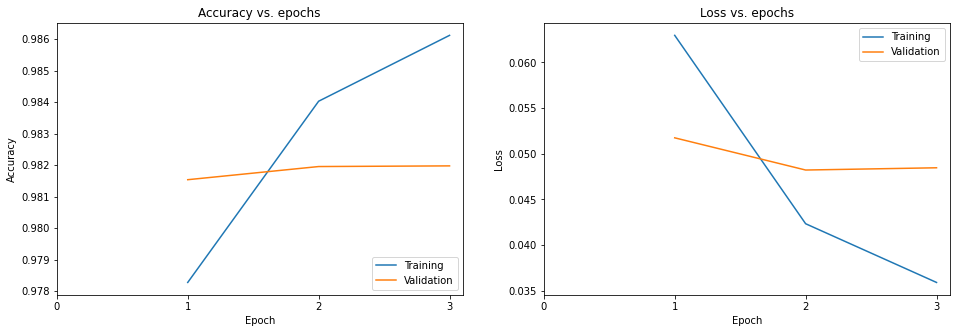

2021-07-24 23:31:57,185: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/embedding


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/embedding
----------------------------------------evaluate----------------------------------------


2021-07-24 23:32:51,756: INFO: test loss:0.0485
2021-07-24 23:32:51,757: INFO: test binary_accuracy:0.9820
2021-07-24 23:32:51,757: INFO: test auc:0.5907
2021-07-24 23:32:51,759: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/results.json
2021-07-24 23:32:51,760: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/results.json
2021-07-24 23:32:51,761: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/sequence_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-07-24 23:32:51,765: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-07-24 23:32:51,806: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/sequence_map.layer/assets


2021-07-24 23:32:52,354: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/sequence_map.layer/assets
2021-07-24 23:32:52,378: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/sequence_map.generator


----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_binary_accuracy,test_binary_accuracy,train_auc,test_auc
1,embedding,6002406,388.4,0.0294,0.0485,0.9888,0.9820,0.6447,0.5907
2,mlp1,7681798,109.4,0.0543,0.0668,0.9811,0.9771,0.5034,0.4722
3,mlp2,7681798,162.8,0.0746,0.0897,0.9753,0.9716,0.5004,0.5058


In [43]:
# helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets1)
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.models.embedding1(helper, name='embedding', last_activation='sigmoid')
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

#### embedding_ft

In [44]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.models.embedding1(helper, name='embedding_ft',
                                             embedding_matrix=embedding_matrix_fasttext,
                                             is_embedding_trainable=False)
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

2021-07-24 23:32:52,483: INFO: model_params.embedding_ft.dropout=0.4
2021-07-24 23:32:52,484: INFO: model_params.embedding_ft.embedding_dim=200
2021-07-24 23:32:52,528: INFO: output_bias=[-0.83046516 -3.09185542 -1.42323626 -4.31073893 -1.49321114 -3.22567087]
2021-07-24 23:32:52,536: INFO: learning_rate=0.001
2021-07-24 23:32:52,536: INFO: model_params.embedding_ft.clip_value=None
2021-07-24 23:32:52,542: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/embedding_ft
2021-07-24 23:32:52,544: INFO: model_params.embedding_ft.epochs=3
2021-07-24 23:32:52,545: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/toxicity-16k/toxicity-16k_0721_p100/embedding_ft, monitor=val_binary_accuracy)
2021-07-24 23:32:52,545: INFO: use EarlyStopping(monitor=val_binary_accuracy, patience=40)
2021-07-24 23:32:52,546: INFO: use ReduceLROnPlatea

TensorSpec(shape=(32, 100), dtype=tf.int64, name=None)
30000 300
Model: "embedding_ft"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 300)     9000000     input_12[0][0]                   
__________________________________________________________________________________________________
global_average_pooling1d_2 (Glo (None, 300)          0           embedding_2[0][0]                
__________________________________________________________________________________________________
global_max_pooling1d_2 (GlobalM (None, 300)          0           embedding_2[0][0]                
______________________

2021-07-24 23:32:53,757: INFO: finish training [elapsed time: 1.21 seconds]


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (embedding_ft/dense_14/BiasAdd:0) = ] [[-0.795425594 -3.39343834 -1.53131676...]...] [y (Cast_8/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/else/_1/assert_greater_equal/Assert/AssertGuard/Assert}}]]
	 [[assert_less_equal/Assert/AssertGuard/pivot_f/_13/_33]]
  (1) Invalid argument:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (embedding_ft/dense_14/BiasAdd:0) = ] [[-0.795425594 -3.39343834 -1.53131676...]...] [y (Cast_8/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/else/_1/assert_greater_equal/Assert/AssertGuard/Assert}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_3308363]

Function call stack:
train_function -> train_function


### sepCNN

#### sepcnn

In [ ]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.models.sepcnn1(helper, name='sepcnn', blocks=1, last_activation='sigmoid')
# when bolcks=2, the model can't converg
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

#### sepcnn_ft

In [ ]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.models.sepcnn1(helper, name='sepcnn_ft', blocks=1,
                                          embedding_matrix=embedding_matrix_fasttext,
                                          is_embedding_trainable=False, last_activation='sigmoid')
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

### LSTM

#### rnn_lstm

In [ ]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.models.lstm1(helper, name='rnn_lstm', last_activation='sigmoid')
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

#### rnn_lstm_ft

In [ ]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.models.lstm1(helper, name='rnn_lstm_ft',
                                        embedding_matrix=embedding_matrix_fasttext,
                                        is_embedding_trainable=False,
                                        mask_zero=False, 
                                        last_activation='sigmoid'))
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

### Pooled GRU 

#### pg_default

In [ ]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.models.pooled_gru1(helper, name='pg_default', last_activation='sigmoid')
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

#### pg_ft

In [ ]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.models.pooled_gru1(helper, name='pg_ft', 
                                              embedding_matrix=embedding_matrix_fasttext, 
                                              is_embedding_trainable=False,
                                              last_activation='sigmoid')
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

## 评估

### 最佳模型

In [ ]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

In [ ]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

In [ ]:
qtf.utils.plot_sample_text_analysis(predictors, test_texts, test_labels,
                                    sample_count=5, show_error_sample=False) 

In [ ]:
qtf.utils.plot_sample_text_analysis(predictors, test_texts, test_labels,
                                    sample_count=5, show_error_sample=True) 

### 评估

In [ ]:
results = best_predictor.evaluate(test_texts, test_labels)
print(results)

predictions = best_predictor.predict(test_texts)
print(predictions.shape)

In [ ]:
top1_predictions = best_predictor.predict_top_k(test_texts, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

In [ ]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)